In [ ]:
# Генератор данных, удаление шума, удаление периодического шума
# Метрики: SSIM, MSE. Сравните изображения.
# Изображения в оттенках серого.
# Задача 3.1
# Выполните фильтрацию изображений при  помощи преобразования Фурье.
# Сравните результаты фильтрации с алгоритмами, реализованными в task 1.
# Задача 3.2
# Обновите генератор, который Вы создали в task_1.
# Добавьте деградационный периодический шум (покомпонентноее умножение исходного и зашумленного изображения). н
# Выполните фильтрацию периодического шума при  помощи преобразования Фурье.
# Оцените качество фильтрации.
# Примеры деградационного периодического шума.


Adding periodic noise...


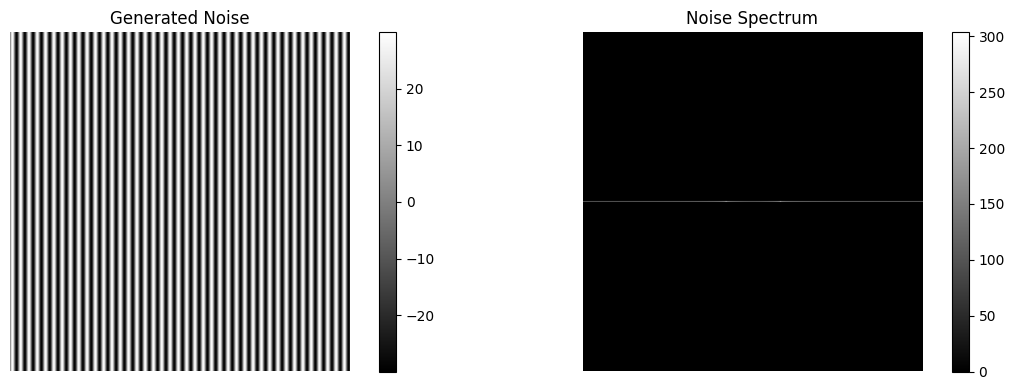


Applying Fourier filtering...


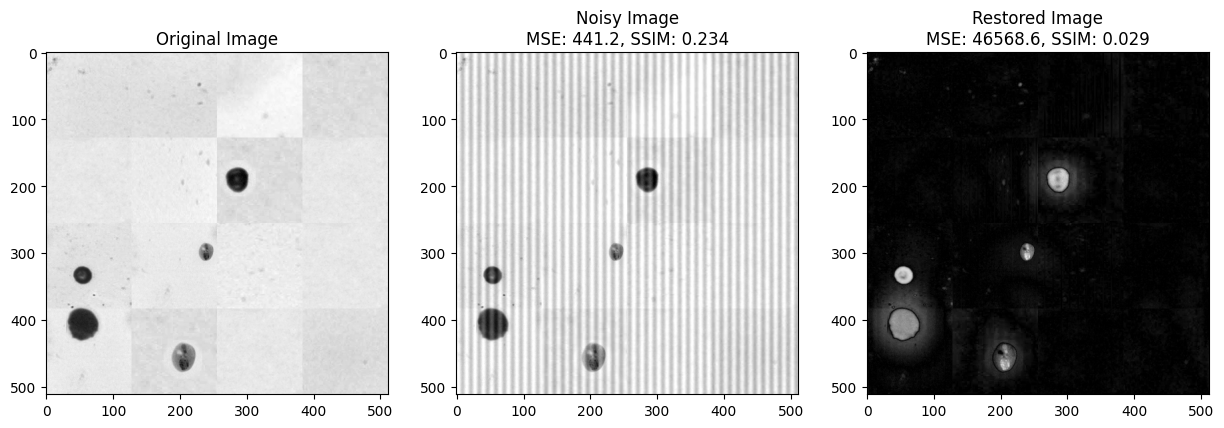

In [ ]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity

def load_patches_from_folder(folder_path):
    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                patches.append(img)
    return patches

def generate_background(background_patches, output_size=(512, 512)):
    bg = np.zeros(output_size, dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            patch = random.choice(background_patches)
            patch = cv2.resize(patch, (patch_size, patch_size))
            bg[i:i+patch_size, j:j+patch_size] = patch
    return bg

def add_objects(background, object_patches, num_objects=5):
    output = background.copy()

    for _ in range(num_objects):
        obj = random.choice(object_patches)
        size = random.randint(30, 70)
        obj = cv2.resize(obj, (size, size))

        x = random.randint(0, background.shape[0] - size)
        y = random.randint(0, background.shape[1] - size)


        mask = np.zeros_like(obj, dtype=np.float32)
        cv2.circle(mask, (size//2, size//2), size//2, 1, -1)
        mask = cv2.GaussianBlur(mask, (15, 15), 0)

        output[x:x+size, y:y+size] = (
            output[x:x+size, y:y+size] * (1 - mask) +
            obj * mask
        ).astype(np.uint8)

    return output

def add_periodic_noise(image, freq=0.1, amplitude=30):
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    noise = amplitude * np.sin(2 * np.pi * freq * xx)
    noisy_image = image.astype(np.float32) + noise

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(noise, cmap='gray')
    plt.title('Generated Noise')
    plt.colorbar()
    plt.axis('off')

    fft_noise = np.fft.fft2(noise)
    fft_shift = np.fft.fftshift(fft_noise)
    magnitude_spectrum = 20 * np.log(np.abs(fft_shift) + 1)

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Noise Spectrum')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def fourier_denoise(noisy_image, freq=0.1, threshold=20):

    dft = np.fft.fft2(noisy_image)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = noisy_image.shape
    crow, ccol = rows // 2, cols // 2
    freq_pixels = int(freq * cols)

    mask = np.ones((rows, cols), np.uint8)
    radius = 5
    for i in [-1, 0, 1]:
        cv2.circle(mask, (ccol + i*freq_pixels, crow), radius, 0, -1)

    # Apply mask and inverse FFT
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    restored = np.fft.ifft2(f_ishift)
    restored = np.abs(restored)

    return np.clip(restored, 0, 255).astype(np.uint8)

def visualize_results(original, noisy, restored):
    """Compare original, noisy and restored images"""
    mse = mean_squared_error(original, noisy)
    ssim = structural_similarity(original, noisy)

    mse_restored = mean_squared_error(original, restored)
    ssim_restored = structural_similarity(original, restored)

    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(original, cmap='gray')
    plt.title('Original Image')

    plt.subplot(132), plt.imshow(noisy, cmap='gray')
    plt.title(f'Noisy Image\nMSE: {mse:.1f}, SSIM: {ssim:.3f}')

    plt.subplot(133), plt.imshow(restored, cmap='gray')
    plt.title(f'Restored Image\nMSE: {mse_restored:.1f}, SSIM: {ssim_restored:.3f}')
    plt.show()


if __name__ == "__main__":

    background_patches = load_patches_from_folder('background')
    object_patches = load_patches_from_folder('patches')

    # Generate base image
    background = generate_background(background_patches)
    original = add_objects(background, object_patches)

    # Add periodic noise
    print("\nAdding periodic noise...")
    noisy = add_periodic_noise(original, freq=0.08, amplitude=30)

    # Apply Fourier denoising
    print("\nApplying Fourier filtering...")
    restored = fourier_denoise(noisy, freq=0.08)

    visualize_results(original, noisy, restored)